## MLP with CIFAR-10 Dataset

#### Module Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0  Device: cuda


In [5]:
BATCH_SIZE = 32
EPOCHS = 10

#### Data Download

In [7]:
train_dataset = datasets.CIFAR10(root='./data/CIFAR_10',
                                train=True,
                                download=True,
                                transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data/CIFAR_10',
                                train=False,
                                transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size = BATCH_SIZE,
                                        shuffle = False)                                        

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR_10\cifar-10-python.tar.gz to ./data/CIFAR_10


In [8]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type: ', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type:  torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


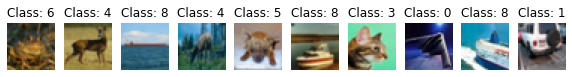

In [9]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [17]:
print(X_train[0].shape)
print(np.transpose(X_train[0], (1, 2, 0)).shape)

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


In [13]:
print(y_train[0])
print(y_train[0].item())

tensor(6)
6


#### MLP Modeling

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [20]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion = nn.CrossEntropyLoss() # MLP 모델의 output 값과 계산될 Label 값은 Class를 표현하는 원-핫 인코딩 값이므로 CrossEntropy Loss를 통해 계산

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [27]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [25]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1] # MLP 모델의 Ouput은 크기가 '10'인 벡터 값, 계산된 벡터 값 내의 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [28]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)] 	 Train Loss: 2.571764
Train Epoch: 1 [6400/50000(13%)] 	 Train Loss: 2.075308
Train Epoch: 1 [12800/50000(26%)] 	 Train Loss: 1.985105
Train Epoch: 1 [19200/50000(38%)] 	 Train Loss: 1.805690
Train Epoch: 1 [25600/50000(51%)] 	 Train Loss: 1.850420
Train Epoch: 1 [32000/50000(64%)] 	 Train Loss: 2.105442
Train Epoch: 1 [38400/50000(77%)] 	 Train Loss: 1.863906
Train Epoch: 1 [44800/50000(90%)] 	 Train Loss: 1.569254

[EPOCH: 1], 	Test Loss: 1.7167, 	Test Accuracy: 38.20 % 

Train Epoch: 2 [0/50000(0%)] 	 Train Loss: 1.858403
Train Epoch: 2 [6400/50000(13%)] 	 Train Loss: 1.670603
Train Epoch: 2 [12800/50000(26%)] 	 Train Loss: 1.514552
Train Epoch: 2 [19200/50000(38%)] 	 Train Loss: 1.650537
Train Epoch: 2 [25600/50000(51%)] 	 Train Loss: 1.896354
Train Epoch: 2 [32000/50000(64%)] 	 Train Loss: 1.420149
Train Epoch: 2 [38400/50000(77%)] 	 Train Loss: 1.701821
Train Epoch: 2 [44800/50000(90%)] 	 Train Loss: 1.448441

[EPOCH: 2], 	Test Loss: 1.6384, 	Test Ac